In [1]:
from unityagents import UnityEnvironment
import numpy as np
import time
import matplotlib.pyplot as plt
from agent import Agent
from collections import deque

import torch

In [2]:
#Single Agent reacher
env = UnityEnvironment(file_name='../../unity/Reacher_multi.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## Examine State and Action Space

<p>
In this environment, a double-jointed arm can move to target locations. A reward of +0.1 is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.
</p>
<p>
The observation space consists of 33 variables corresponding to position, rotation, velocity, and angular velocities of the arm. Each action is a vector with four numbers, corresponding to torque applicable to two joints. Every entry in the action vector must be a number between -1 and 1.
</p>

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## Random Walk

In [5]:
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
i = 0
while True:
    i+=1
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        print(i)
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

1001
Total score (averaged over agents) this episode: 0.16349999634549023


# DDPG Implementation

In [6]:
state_dim = int(env_info.vector_observations.shape[1])
action_dim = int(brain.vector_action_space_size)

In [7]:
def ddpg(n_episodes=1000, max_t=1000):
    """ Deep Deterministic Policy Gradients
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
    """
    scores_window = deque(maxlen=100)
    scores = np.zeros(num_agents)
    scores_episode = []
    
    agents =[] 
    
    for i in range(num_agents):
        #Declare Agent class and append to memory
        agents.append(Agent(state_dim, action_dim, random_seed=0))
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        for agent in agents:
            agent.reset()
            
        scores = np.zeros(num_agents)
            
        for t in range(max_t):
            actions = np.array([agents[i].act(states[i]) for i in range(num_agents)]).squeeze(1)
            env_info = env.step(actions)[brain_name]        # send the action to the environment
            next_states = env_info.vector_observations     # get the next state
            rewards = env_info.rewards                     # get the reward
            dones = env_info.local_done        
            
            for i in range(num_agents):
                agents[i].step(t, states[i], actions[i], rewards[i], next_states[i], dones[i]) 
 
            states = next_states
            scores += rewards
            if t % 20:
                print('\rTimestep {}\tScore: {:.2f}\tmin: {:.2f}\tmax: {:.2f}'
                      .format(t, np.mean(scores), np.min(scores), np.max(scores)), end="") 
            if np.any(dones):
                break 
        score = np.mean(scores)
        scores_window.append(score)       # save most recent score
        scores_episode.append(score)

        print('\rEpisode {}\tScore: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, score, np.mean(scores_window)), end="\n")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(Agent.actor_local.state_dict(), '../models/checkpoint_actor.pth')
            torch.save(Agent.critic_local.state_dict(), '../models/checkpoint_critic.pth')
            break
            
    return scores_episode

In [ ]:
scores = ddpg()

Episode 1	Score: 0.14	Average Score: 0.14.16
Episode 2	Score: 0.82	Average Score: 0.48.02
Episode 3	Score: 1.36	Average Score: 0.77.44
Episode 4	Score: 1.75	Average Score: 1.02.65
Episode 5	Score: 2.27	Average Score: 1.27.82
Episode 6	Score: 2.84	Average Score: 1.53.67
Episode 7	Score: 3.60	Average Score: 1.832.08
Episode 8	Score: 3.64	Average Score: 2.05.59
Episode 9	Score: 4.11	Average Score: 2.28.51
Episode 10	Score: 4.73	Average Score: 2.53.40
Episode 11	Score: 4.73	Average Score: 2.73.85
Episode 12	Score: 6.02	Average Score: 3.0077
Episode 13	Score: 4.93	Average Score: 3.15.60
Episode 14	Score: 6.74	Average Score: 3.41.23
Episode 15	Score: 6.37	Average Score: 3.6066
Episode 16	Score: 8.42	Average Score: 3.90.93
Episode 17	Score: 7.71	Average Score: 4.13.22
Episode 18	Score: 7.74	Average Score: 4.33.75
Episode 19	Score: 6.65	Average Score: 4.45.04
Episode 20	Score: 8.52	Average Score: 4.65.59
Episode 21	Score: 8.32	Average Score: 4.83.46
Episode 22	Score: 8.35	Average Score: 4.99.2

Episode 343	Score: 22.11	Average Score: 24.3486
Episode 344	Score: 23.81	Average Score: 24.3164
Episode 345	Score: 23.33	Average Score: 24.2835
Episode 346	Score: 25.82	Average Score: 24.2783
Episode 347	Score: 24.78	Average Score: 24.2422
Episode 348	Score: 23.15	Average Score: 24.2210
Timestep 99	Score: 2.05	min: 0.77	max: 3.44

# Analysis

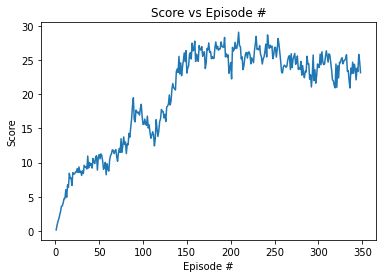

In [108]:
#Display Scores
fig = plt.figure()
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title("Score vs Episode #")
plt.show()

### Test the model

In [8]:
from actor import Actor
from critic import Critic

In [20]:
#define seed
random_seed = 9
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #Enable cuda if available

#Load actor weights
Agent.actor_local = Actor(state_size, action_size, random_seed).to(device)
Agent.actor_local.load_state_dict(torch.load('../models/checkpoint_actor.pth', map_location=device))

#Load critic weights
Agent.critic_local = Critic(state_size, action_size, random_seed).to(device)
Agent.critic_local.load_state_dict(torch.load('../models/checkpoint_critic.pth', map_location=device))

<All keys matched successfully>

In [21]:
#load 20 parallel agents
agents = [] 
for i in range(num_agents):
    agents.append(Agent(state_size, action_size, random_seed=random_seed))

In [28]:
# test model
env_info = env.reset(train_mode=True)[brain_name] #reset env
scores = np.zeros(num_agents)
while True:
    actions = np.array([agents[i].act(states[i]) for i in range(num_agents)]).squeeze(1)
    env_info = env.step(actions)[brain_name]        # send the action to the environment
    next_states = env_info.vector_observations     # get the next state
    rewards = env_info.rewards                     # get the reward
    dones = env_info.local_done        

    states = next_states
    scores += rewards

    print('\rScore: {:.2f}\tmin: {:.2f}\tmax: {:.2f}'
              .format(np.mean(scores), np.min(scores), np.max(scores)), end="") 
    
    if np.any(dones):
        break

Score: 32.85	min: 23.59	max: 38.33

In [23]:
###The end!